# OneClassSVM - Train model on ASTRO data + predict on UNIDs

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [221]:
# Load dataset
data_path = "../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
print(df_astro.columns)

df_astro.head()

Index(['E_peak', 'beta', 'sigma', 'beta_Rel', 'class'], dtype='object')


,E_peak,beta,sigma,beta_Rel,class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


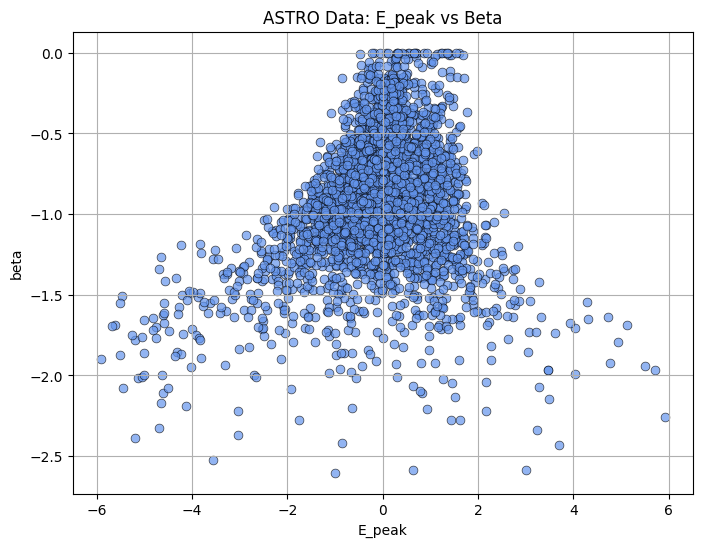

In [ ]:
# Comprobamos la distribución de los datos astro antes de escalar
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_astro,
    x="E_peak",
    y="beta",
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

In [ ]:
X = df_astro[["beta", "E_peak"]].values
y = df_astro["class"].values

# SPLIT: Train / Val / Test
# Dividimos todo astro en train y temp
# y después dividimos temp en val y test
# 60% train, 20% val, 20% test
# de esta manera, el test set no se ve en el entrenamiento
# y el val set se usa para ajustar los hiperparámetros
X_train, X_temp = train_test_split(X, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


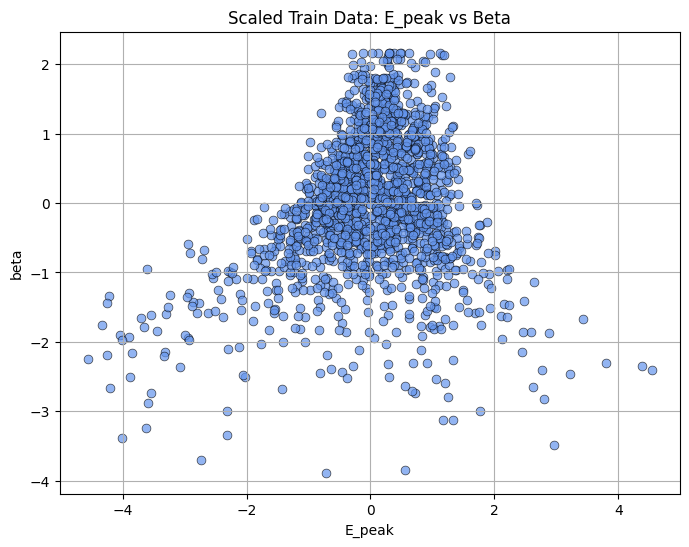

In [ ]:
# Comprobamos que los datos están bien escalados
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x=X_train_scaled[:, 1],
    y=X_train_scaled[:, 0],
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled Train Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()


In [ ]:
# Define hyperparameter ranges:

nu_values = [0.005, 0.01, 0.02, 0.05]
# nu should be a float in the interval (0, 1], by default 0.5
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5)) 
# gamma can be {‘scale’, ‘auto’} or float, default=’scale’
# if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
# if ‘auto’, uses 1 / n_features
# if float, must be non-negative.

# Track results
results = []
best_score = np.inf
best_model = None
best_params = {}

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)
        
        # Predict on validation set
        preds = model.predict(X_val_scaled)
        n_outliers = np.sum(preds == -1)  # -1 means "anomaly"
        
        results.append({'nu': nu, 'gamma': gamma, 'outliers': n_outliers})
        
        if n_outliers < best_score:
            best_score = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Show best hyperparameters
print(f"✅ Best Parameters: nu = {best_params['nu']}, gamma = {best_params['gamma']}")
print(f"🚨 Outliers on Validation Set: {best_score}")


✅ Best Parameters: nu = 0.005, gamma = 0.1
🚨 Outliers on Validation Set: 4


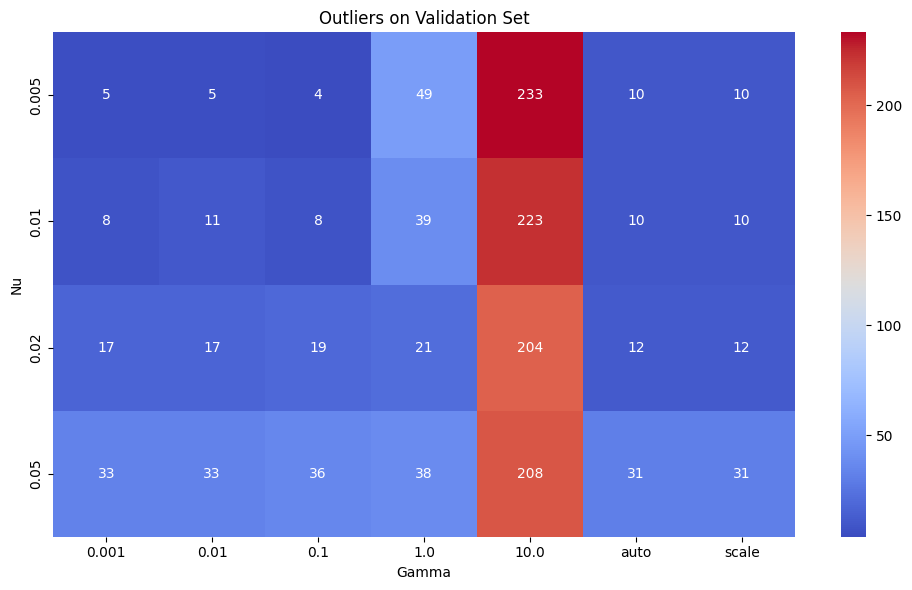

In [226]:
df_results = pd.DataFrame(results)
df_results['gamma_str'] = df_results['gamma'].astype(str)
heatmap_data = df_results.pivot(index='nu', columns='gamma_str', values='outliers')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')
plt.title("Outliers on Validation Set")
plt.xlabel("Gamma")
plt.ylabel("Nu")
plt.tight_layout()
plt.show()


In [227]:
# Evaluate on the test set
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)

print(f"🔍 Outliers on Final Test Set: {n_test_outliers}")

🔍 Outliers on Final Test Set: 6


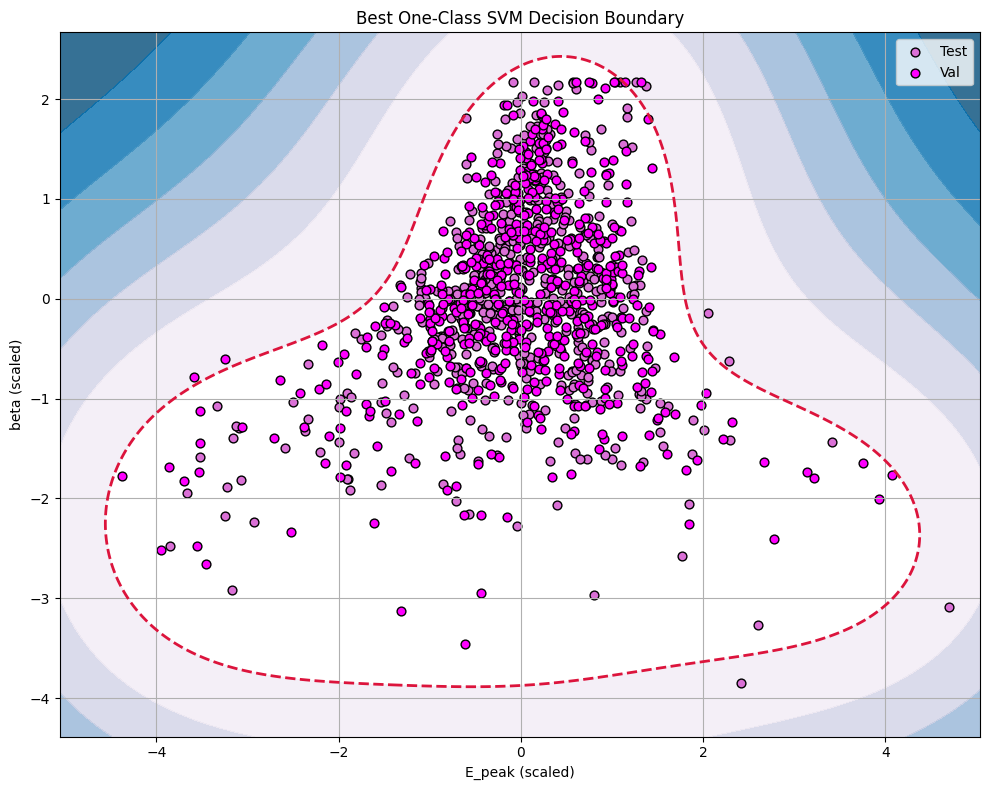

In [228]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

grid = np.c_[yy.ravel(), xx.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
# plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='Train')
plt.scatter(X_test_scaled[:, 1], X_test_scaled[:, 0], c='orchid', edgecolors='k', s=40, label='Test')
plt.scatter(X_val_scaled[:, 1], X_val_scaled[:, 0], c='magenta', edgecolors='k', s=40, label='Val')


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Generate random 'noise' in data for testing Precision and Recall

In [229]:
rng = np.random.RandomState(42)
n_anomalies = 20

# Assuming 2 features (beta and E_peak), generate noise in [-5, 5] range
anomalies = rng.uniform(low=-5, high=5, size=(n_anomalies, 2))
anomalies_scaled = scaler.transform(anomalies)

# Combine normal and fake data
X_eval = np.vstack([X_val_scaled, anomalies_scaled])
y_eval = np.hstack([np.ones(len(X_val_scaled)), -1 * np.ones(len(anomalies_scaled))])  # 1 = normal, -1 = fake anomaly

In [230]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_eval)

print(confusion_matrix(y_eval, y_pred, labels=[1, -1]))
print(classification_report(y_eval, y_pred, target_names=["Normal", "Anomaly"]))


[[562   4]
 [  3  17]]
              precision    recall  f1-score   support

      Normal       0.81      0.85      0.83        20
     Anomaly       0.99      0.99      0.99       566

    accuracy                           0.99       586
   macro avg       0.90      0.92      0.91       586
weighted avg       0.99      0.99      0.99       586



# Predict on UNIDs

In [231]:
unids_path = "../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [232]:
# Apply log10 to columns
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

In [233]:
# Extraer y escalar
X_unids_log = df_unids_log[["beta", "E_peak"]].values
X_unids_scaled = scaler.transform(X_unids_log)

# Predict using the best model
preds_non_astro = best_model.predict(X_unids_scaled)

In [234]:
n_outliers = np.sum(preds_non_astro == -1)
n_normals = np.sum(preds_non_astro == 1)

print(f"🚀 Predicted ASTRO-like: {n_normals}")
print(f"❗ Predicted not ASTRO-like (anomalies): {n_outliers}")


🚀 Predicted ASTRO-like: 1117
❗ Predicted not ASTRO-like (anomalies): 8


/var/folders/m8/9rd44wvx47j51lczw45sffl40000gn/T/ipykernel_18483/3719041574.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


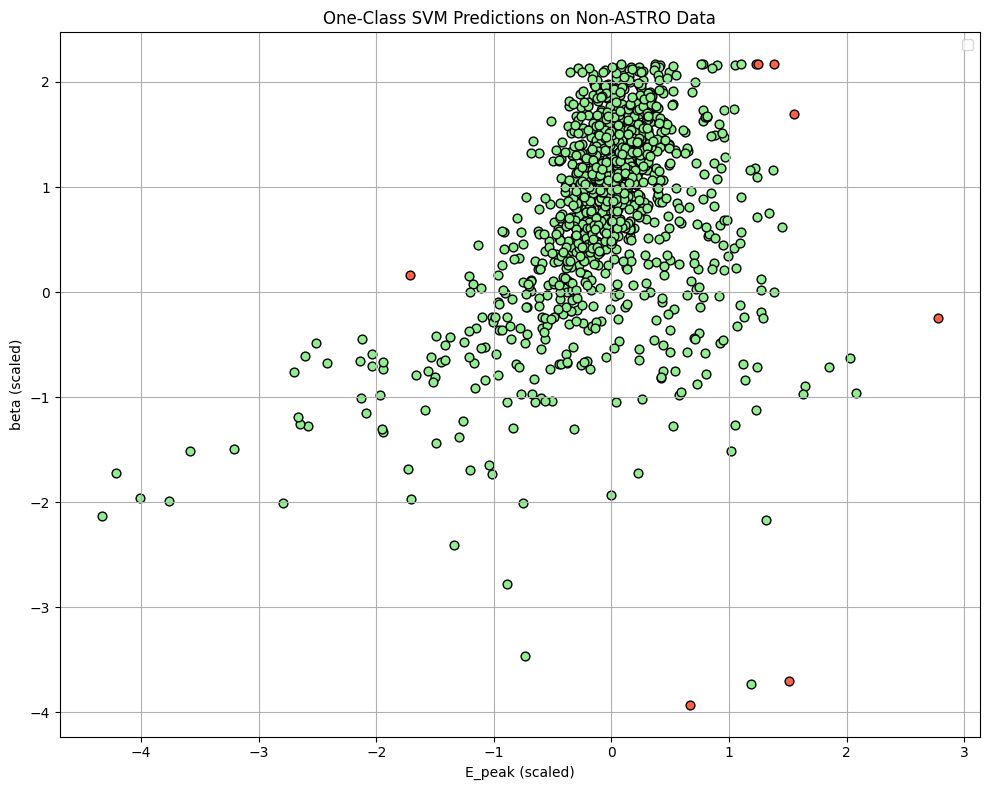

In [235]:
plt.figure(figsize=(10, 8))
plt.scatter(
    X_unids_scaled[preds_non_astro == 1, 1],  # E_peak
    X_unids_scaled[preds_non_astro == 1, 0],  # beta
    # c='lightgreen', edgecolors='k', label='Predicted ASTRO-like', s=40
    c='lightgreen', edgecolors='k', s=40

)

plt.scatter(
    X_unids_scaled[preds_non_astro == -1, 1],
    X_unids_scaled[preds_non_astro == -1, 0],
    # c='tomato', edgecolors='k', label='Anomalies', s=40
    c='tomato', edgecolors='k', s=40

)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("One-Class SVM Predictions on Non-ASTRO Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


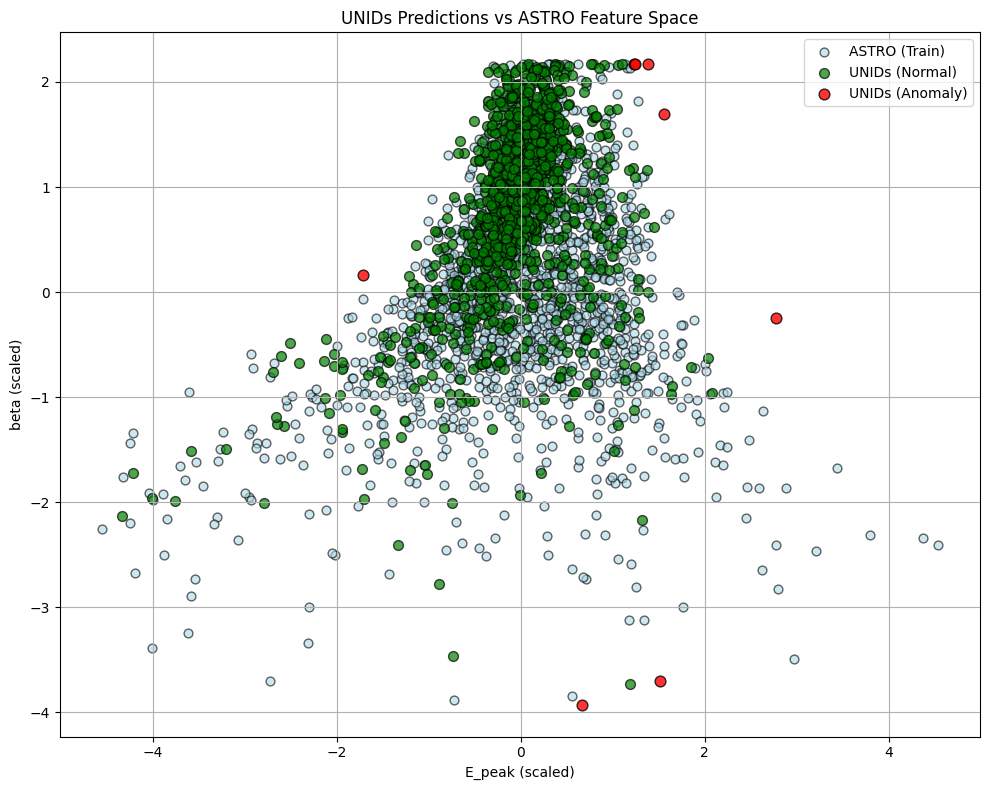

In [236]:
plt.figure(figsize=(10, 8))

# ASTRO data (train set)
plt.scatter(
    X_train_scaled[:, 1], X_train_scaled[:, 0],
    c='lightblue', edgecolors='k', s=40, alpha=0.6, label='ASTRO (Train)'
)

# Non-ASTRO predicted as normal
plt.scatter(
    X_unids_scaled[preds_non_astro == 1, 1],
    X_unids_scaled[preds_non_astro == 1, 0],
    c='green', edgecolors='k', s=50, alpha=0.7, label='UNIDs (Normal)'
)

# Non-ASTRO predicted as anomalies
plt.scatter(
    X_unids_scaled[preds_non_astro == -1, 1],
    X_unids_scaled[preds_non_astro == -1, 0],
    c='red', edgecolors='k', s=60, alpha=0.8, label='UNIDs (Anomaly)'
)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNIDs Predictions vs ASTRO Feature Space")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


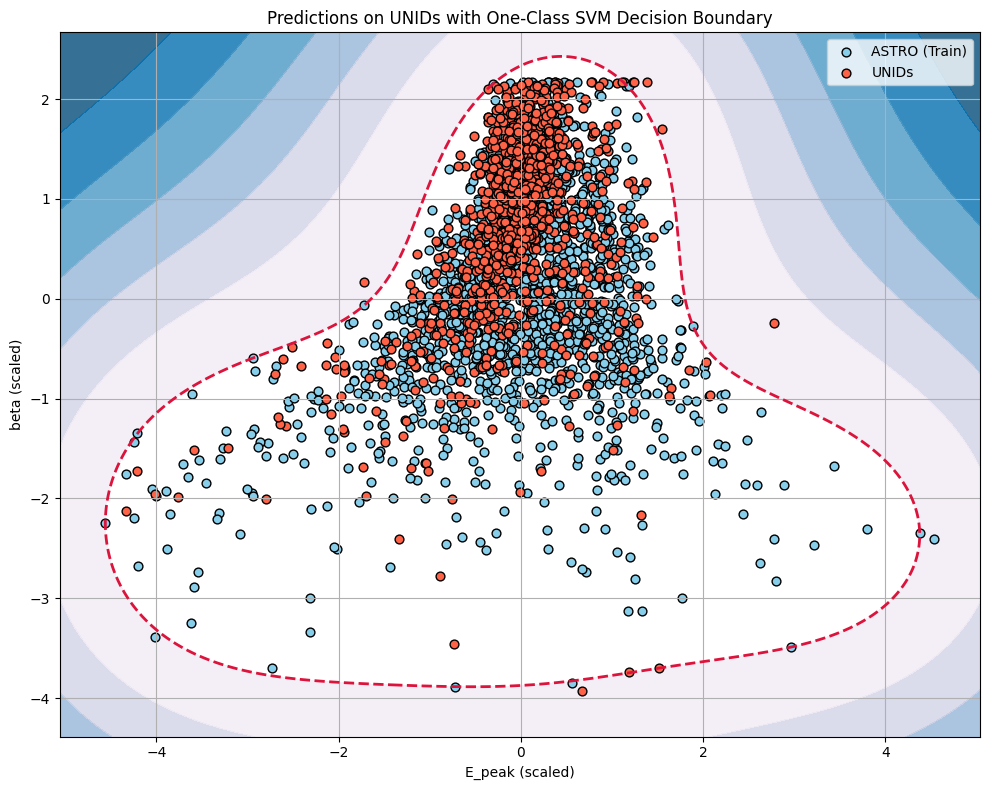

In [237]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

grid = np.c_[yy.ravel(), xx.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='ASTRO (Train)')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='orchid', edgecolors='k', s=40, label='Test')
plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='tomato', edgecolors='k', s=40, label='UNIDs')


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Predictions on UNIDs with One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Anomaly Scoring - UNIDs

In [238]:
from sklearn.preprocessing import MinMaxScaler

# Get decision scores
scores = best_model.decision_function(X_unids_scaled)  # higher = more normal

# Invert scores so that higher = more anomalous
anom_scores = -scores

# Normalize to 0–100% range
scaler_scores = MinMaxScaler(feature_range=(0, 100))
anom_percent = scaler_scores.fit_transform(anom_scores.reshape(-1, 1)).flatten()


In [239]:
most_anomalous_idx = np.argsort(scores)[:10]

top_anomalies = df_unids_log.iloc[most_anomalous_idx].copy()
top_anomalies['Anomaly_Score'] = anom_scores[most_anomalous_idx]
top_anomalies['Anomaly_%'] = anom_percent[most_anomalous_idx]

# Add anomaly scores to all UNIDs
df_unids_log['Anomaly_Score'] = anom_scores
df_unids_log['Anomaly_%'] = anom_percent

top_ocsvm_unids = df_unids_log.sort_values('Anomaly_%', ascending=False).head(10)
print("🔝 Top 10 Most Anomalous UNIDs (OCSVM):")
display(top_ocsvm_unids[['number', 'beta', 'E_peak', 'Anomaly_%']])



🔝 Top 10 Most Anomalous UNIDs (OCSVM):


,number,beta,E_peak,Anomaly_%
1054,1054,-1.037631,3.469896,100.000000
1017,1017,-0.000087,1.682984,79.570690
275,275,-0.862013,-2.278140,73.478002
1116,1116,-2.619789,0.771404,72.713235
307,307,0.000000,1.510143,71.698746
240,240,-0.000391,1.493960,70.966592
287,287,-0.201695,1.902302,70.775459
126,126,-2.522879,1.852297,65.672412
1043,1043,-0.029467,-0.537962,65.003582
564,564,-2.537602,1.438969,64.974474


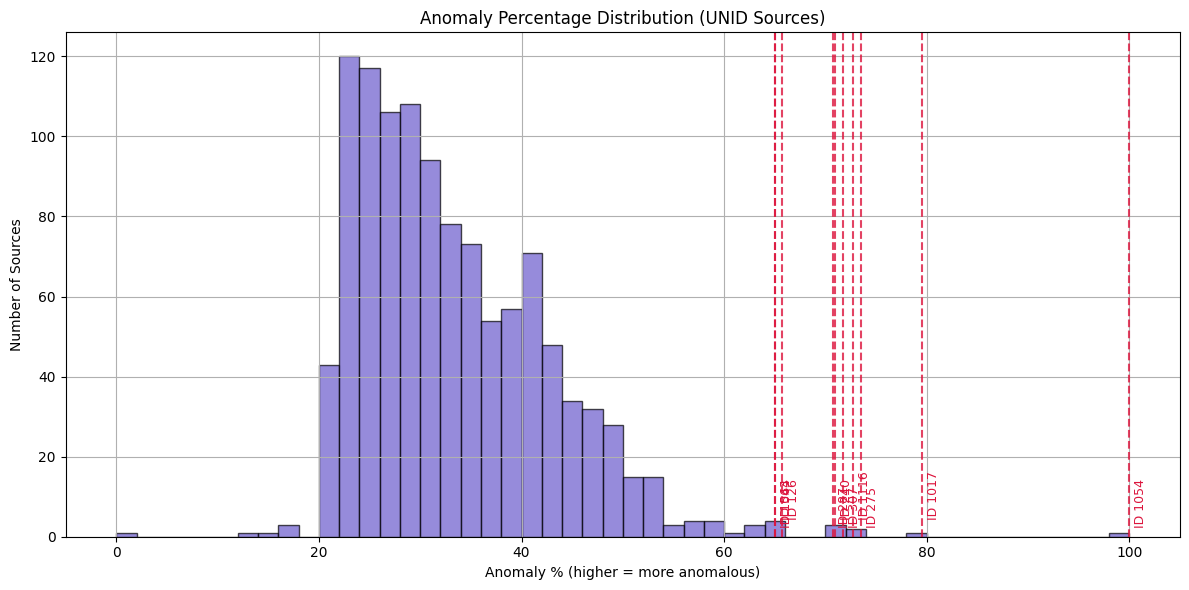

In [240]:
# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids_log.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='slateblue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


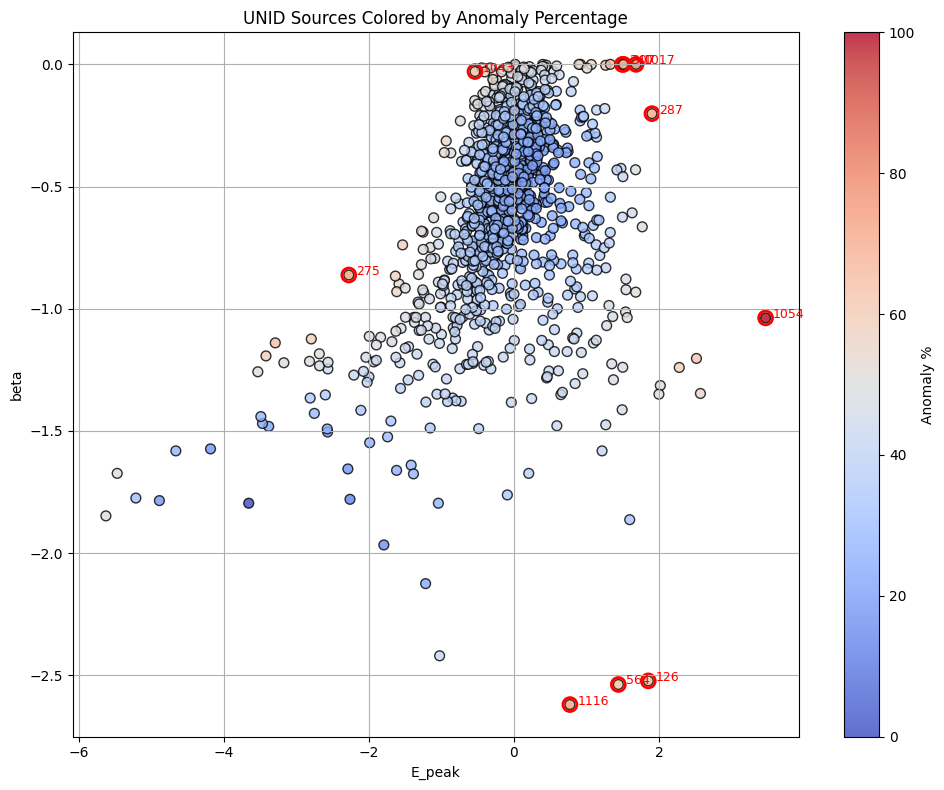

In [241]:
E_peak = df_unids_log['E_peak'].values
beta = df_unids_log['beta'].values

anom_percent_colored = anom_percent

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    E_peak, beta,
    c=anom_percent_colored,
    cmap='coolwarm',  # or 'plasma', 'coolwarm', 'viridis', 'inferno'
    s=50,
    edgecolors='k',
    alpha=0.8
)

# Color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Anomaly %')

# Highlight top 10 anomalies with red circles
for idx in most_anomalous_idx:
    plt.scatter(
        E_peak[idx], beta[idx],
        facecolors='none', edgecolors='red', linewidths=2, s=100
    )
    plt.text(
        E_peak[idx] + 0.1, beta[idx],
        f"{int(df_unids_log.iloc[idx]['number'])}",  # ID label
        color='red', fontsize=9
    )

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("UNID Sources Colored by Anomaly Percentage")
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparar con UNIDs ANN

In [242]:
ann_unids_path = "./4F_ANN/unids_DM_std_proba_check_repeated_kfold_rskf_4F_21.txt"

raw_ann_unids_data = np.genfromtxt(ann_unids_path, dtype='str')
ann_unids_data = np.asarray(raw_ann_unids_data[1:], dtype=float)  # Salta cabecera
n_samples = ann_unids_data.shape[1] - 1

columns = ['number'] + [f'prob_{i}' for i in range(n_samples)]
df_unids_ann = pd.DataFrame(ann_unids_data, columns=columns)

df_unids_ann.head()

,number,prob_0
0,0.0,6.583166e-10
1,1.0,3.137251e-01
2,2.0,4.082428e-01
3,3.0,9.984947e-02
4,4.0,2.016772e-01


In [243]:
# Media por fuente y entre folds
df_mean_unids_ann = df_unids_ann.groupby('number').mean().reset_index()
df_mean_unids_ann['prob_ann'] = df_mean_unids_ann[[f'prob_{i}' for i in range(n_samples)]].mean(axis=1)

df_mean_unids_ann.head()

,number,prob_0,prob_ann
0,0.0,1.860129e-10,1.860129e-10
1,1.0,3.032059e-01,3.032059e-01
2,2.0,5.515580e-01,5.515580e-01
3,3.0,1.494101e-01,1.494101e-01
4,4.0,2.391825e-01,2.391825e-01


In [244]:
# Get the 10 sources with the highest mean ANN DM probability
top_ann_unids = df_mean_unids_ann.sort_values('prob_ann', ascending=False).head(10)

# Display results
print("🔝 Top 10 UNIDs with highest ANN-based DM probability:")
display(top_ann_unids[['number', 'prob_ann']])


🔝 Top 10 UNIDs with highest ANN-based DM probability:


,number,prob_ann
33,33.0,1.000000
843,843.0,0.999999
709,709.0,0.999995
923,923.0,0.999552
1054,1054.0,0.999522
1107,1107.0,0.999414
717,717.0,0.998058
477,477.0,0.997570
1103,1103.0,0.994799
542,542.0,0.994276


In [245]:
df_compare = pd.merge(df_mean_unids_ann[['number', 'prob_ann']],
                      df_unids_log[['number', 'Anomaly_%']],
                      on='number')

df_compare.sort_values(['prob_ann', 'Anomaly_%'], ascending=[False, False]).head(10)


,number,prob_ann,Anomaly_%
33,33.0,1.000000,28.769370
843,843.0,0.999999,29.852710
709,709.0,0.999995,28.947387
923,923.0,0.999552,33.919744
1054,1054.0,0.999522,100.000000
1107,1107.0,0.999414,38.973824
717,717.0,0.998058,22.552814
477,477.0,0.997570,24.202793
1103,1103.0,0.994799,51.334369
542,542.0,0.994276,35.536818


In [246]:
df_compare[
    (df_compare['prob_ann'] > 0.9) & 
    (df_compare['Anomaly_%'] > 80)
]


,number,prob_ann,Anomaly_%
1054,1054.0,0.999522,100.0
